In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [182]:
# Set the display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [102]:
data_path=fr"C:\Users\gaspa\OneDrive\Achat appartement\Joseph de Maistre\Extrait_dvf.csv"

In [103]:
df_raw=pd.read_csv(data_path)

c:\Users\gaspa\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3269: DtypeWarning: Columns (2,4,5,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,32,35,36,37,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Passage des dates au format dates

In [104]:
# Identify columns that contain "date" in their names
date_cols = [x for x in df_raw.columns if "date" in x]

# Convert the identified columns to datetime
for col in date_cols:
    df_raw[col] = pd.to_datetime(df_raw[col], format='%Y-%m-%d', errors='coerce')

df_raw['annee_mois'] = df_raw['date_mutation'].dt.strftime('%Y-%m')

Conversion des chiffres en float

In [105]:
# Function to convert selected columns to floats when possible
def convert_to_float(df, columns):
    for col in columns:
        if col in df.columns:
            # Convert to numeric, coercing errors to NaN
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# List of columns to convert to floats
columns_to_convert = [x for x in df_raw.columns if 'valeur' in x or 'numero' in x or "nombre_lots" in x or 'surface' in x]

# Apply the function to the DataFrame
df = convert_to_float(df_raw, columns_to_convert)

Calcul d'attributs additionnels

In [106]:
# Calculate the total surface area in square meters (carrez)
# df_raw.loc[:,[x for x in df_raw.columns if "carrez" in x]]=df_raw.loc[:,[x for x in df_raw.columns if "carrez" in x]].fillna(0)
df_raw['total_surface_carrez'] = df_raw[[x for x in df_raw.columns if "carrez" in x]].sum(axis=1)

# # Calculate the price per square meter (prix_m2)
# # Handle division by zero by setting prix_m2 to NaN where total_surface_carrez is zero
# Define the conditions and choices
conditions = [
    df_raw['total_surface_carrez']> 0,
    (df_raw['total_surface_carrez']== 0)&(df_raw['surface_reelle_bati']> 0)
]
choices = [
    df_raw['valeur_fonciere'] / df_raw['total_surface_carrez'],
    df_raw['valeur_fonciere'] / df_raw['surface_reelle_bati']
]

# Use np.select to apply the conditions and choices
df_raw['prix_m2'] = np.select(conditions, choices, default=np.nan)
df_raw['prix_m2']=df_raw['prix_m2']/1000

df_dates=pd.DataFrame(index=df_raw.annee_mois.dropna().unique(),columns=['placer']).fillna(0).sort_index(ascending=True)

Define useful functions

In [107]:
def compute_avg_market_month(df: pd.DataFrame) -> pd.DataFrame :
    # Group by month and calculate the average 'prix_m2'
    df_marche=df.copy().groupby('annee_mois')['prix_m2'].describe().reset_index()
    tbm=df_dates.reset_index().rename(columns={'index':'annee_mois'})
    result=tbm.merge(df_marche,on='annee_mois',how='left').set_index("annee_mois")

    result=result.sort_index(ascending=True)

    # for period in [3,6]:
    for period in [6]:
        for col in ['count', 'mean', 'std', 'min', '25%', '50%','75%', 'max']: 
            result[f'{col}_rol_{period}m'] = result[col].rolling(window=period).mean()
            result[f'{col}_rol_{period}m']=result[f'{col}_rol_{period}m'].fillna(result[col])


    result=result.reset_index().rename(columns={'index':'annee_mois'})


    return result


## Paris - Prix moyen m2

In [108]:
df_paris=df_raw.loc[
                    (df_raw.nature_mutation=='Vente')&
                    (df_raw.type_local=='Appartement')
                    ].copy()


# Group by month and calculate the average 'prix_m2'
df_marche_paris=compute_avg_market_month(df=df_paris)


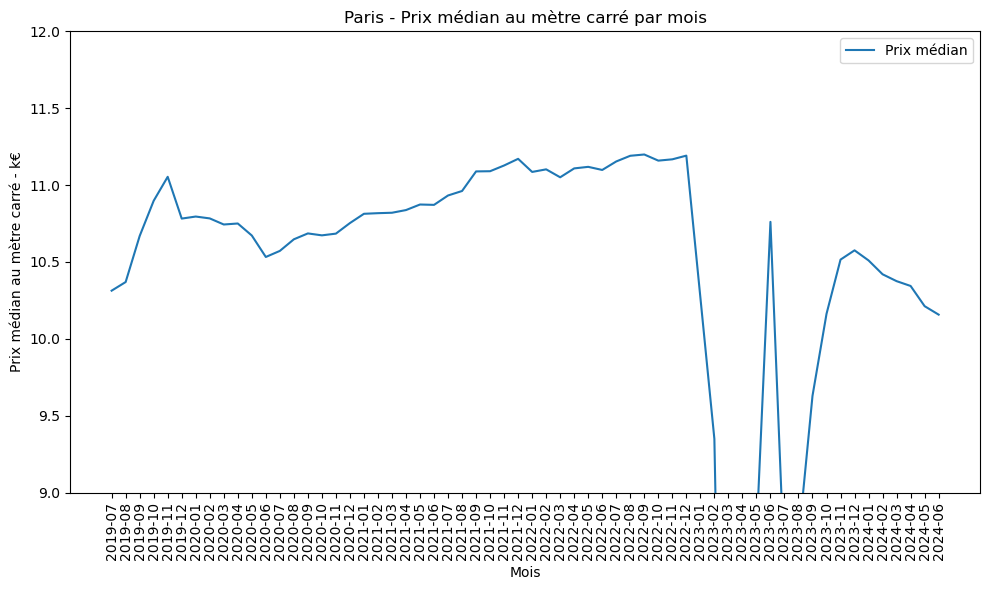

In [111]:
# Plot the line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_marche_paris, x='annee_mois', y='50%_rol_6m', label='Prix médian')

plt.title('Paris - Prix médian au mètre carré par mois')
plt.xlabel('Mois')
plt.ylabel('Prix médian au mètre carré - k€')
plt.ylim(9,12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [112]:
df_marche_paris.sort_index(ascending=False).head(20)

,annee_mois,placer,count,mean,std,min,25%,50%,75%,max,count_rol_6m,mean_rol_6m,std_rol_6m,min_rol_6m,25%_rol_6m,50%_rol_6m,75%_rol_6m,max_rol_6m
59,2024-06,0,8905.0,112.297389,318.053350,0.000006,8.746356,10.792476,28.000000,15937.500000,6379.833333,62.458361,227.638616,0.000064,8.412676,10.157450,15.253854,6904.015952
58,2024-05,0,4714.0,31.511397,139.574850,0.000015,8.349057,10.044730,12.662616,3250.000000,5238.000000,101.406269,335.316171,0.000069,8.381629,10.212455,29.634807,5414.432619
57,2024-04,0,5443.0,112.446103,439.129412,0.000008,8.250000,10.036145,13.529287,13358.333333,4699.500000,105.414868,334.941725,0.000070,8.403116,10.343889,36.234398,5385.586465
56,2024-03,0,6117.0,28.683631,94.518837,0.000007,8.272727,9.977034,12.416667,2434.782609,4247.666667,91.448881,283.733829,0.000070,8.440976,10.375216,36.088718,3885.004027
55,2024-02,0,7011.0,54.803796,271.103680,0.000345,8.358209,9.975787,12.503115,5445.200000,3740.000000,90.078040,281.844880,0.000074,8.519939,10.419915,36.060895,3817.748593
54,2024-01,0,6089.0,35.007848,103.451566,0.000005,8.499709,10.118526,12.411440,998.279769,2830.000000,88.252618,257.016873,0.000020,8.610393,10.509947,36.138266,3127.460685
53,2023-12,0,2054.0,345.984842,964.118680,0.000034,8.560070,11.122507,114.285714,7000.000000,2139.666667,85.998531,248.651959,0.000021,8.660689,10.575587,36.186272,3072.444360
52,2023-11,0,1483.0,55.562988,137.328177,0.000023,8.477980,10.833333,52.260165,3076.923077,1819.666667,39.680761,110.484960,0.001428,8.763409,10.515308,27.118115,2009.944360
51,2023-10,0,2732.0,28.650180,131.882035,0.000006,8.477162,10.224105,12.655208,4354.838710,1574.500000,34.146386,93.108799,0.239519,8.439512,10.162500,20.580886,1513.163463
50,2023-09,0,3071.0,20.458587,83.185143,0.000028,8.746501,10.245232,12.249729,2031.250000,1119.333333,30.541860,83.185143,1.410022,8.197155,9.628986,19.642188,788.527515


## 18ème - prix moyen m2

In [113]:
df_18=df_raw.loc[
                # (df_raw.nature_mutation=='Vente')&
                (df_raw.type_local=='Appartement')
                    &(df_raw.code_postal=='75018')
                    ]

# Group by month and calculate the average 'prix_m2'
df_marche_18=compute_avg_market_month(df_18)

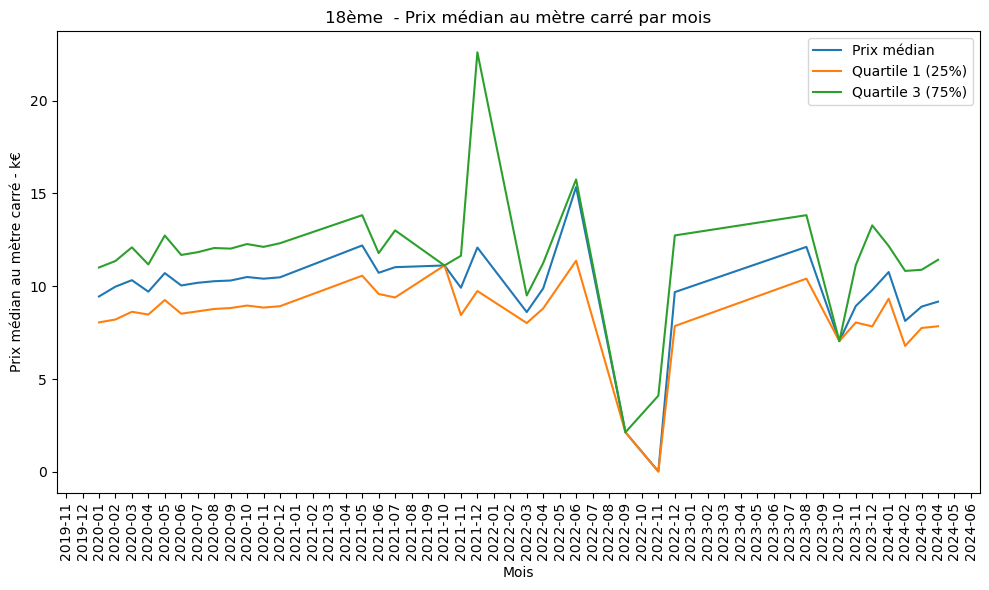

In [114]:
# Plot the line plot using Seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df_marche_18, x='annee_mois', y='prix_m2')
sns.lineplot(data=df_marche_18, x='annee_mois', y='50%_rol_6m', label='Prix médian')
sns.lineplot(data=df_marche_18, x='annee_mois', y='25%_rol_6m', label='Quartile 1 (25%)')
sns.lineplot(data=df_marche_18, x='annee_mois', y='75%_rol_6m', label = 'Quartile 3 (75%)')


plt.title('18ème  - Prix médian au mètre carré par mois')
plt.xlabel('Mois')
plt.ylabel('Prix médian au mètre carré - k€')
# plt.ylim(5,15)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [115]:
df_marche_18.sort_index(ascending=False).head(20)

,annee_mois,placer,count,mean,std,min,25%,50%,75%,max,count_rol_6m,mean_rol_6m,std_rol_6m,min_rol_6m,25%_rol_6m,50%_rol_6m,75%_rol_6m,max_rol_6m
59,2024-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,2024-05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,2024-04,0,139.0,9.060645,3.902029,0.055556,7.605859,8.648170,10.263663,42.028814,100.166667,11.172547,8.343136,1.333237,7.843546,9.169625,11.422385,51.776013
56,2024-03,0,242.0,11.800123,11.734455,0.018182,7.462804,8.747093,10.866194,89.210526,77.166667,10.836051,11.734455,2.497589,7.749514,8.901875,10.885386,45.944822
55,2024-02,0,78.0,11.265206,12.377375,0.006250,6.784127,8.129937,10.824079,89.210526,78.000000,11.265206,12.377375,0.006250,6.784127,8.129937,10.824079,89.210526
54,2024-01,0,3.0,10.741769,2.840783,7.889991,9.326940,10.763889,12.167659,13.571429,3.000000,10.741769,2.840783,7.889991,9.326940,10.763889,12.167659,13.571429
53,2023-12,0,104.0,15.068900,14.365521,0.000034,7.834854,9.794585,13.277181,57.468115,104.000000,15.068900,14.365521,0.000034,7.834854,9.794585,13.277181,57.468115
52,2023-11,0,35.0,9.098640,4.838651,0.029412,8.046691,8.934077,11.135535,19.166667,35.000000,9.098640,4.838651,0.029412,8.046691,8.934077,11.135535,19.166667
51,2023-10,0,1.0,7.041667,NaN,7.041667,7.041667,7.041667,7.041667,7.041667,1.000000,7.041667,NaN,7.041667,7.041667,7.041667,7.041667,7.041667
50,2023-09,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Parcelle cadastrale OAJ

In [180]:
## 18ème - prix moyen m2
df_AJ=df_raw.loc[(df_raw.nature_mutation=='Vente')
                    &(df_raw.type_local=='Appartement')
                    &(df_raw.code_postal=='75018')
                    &(df_raw.section_prefixe=="000AJ")
                    ]

# Group by month and calculate the average 'prix_m2'
df_marche_AJ=compute_avg_market_month(df_AJ)

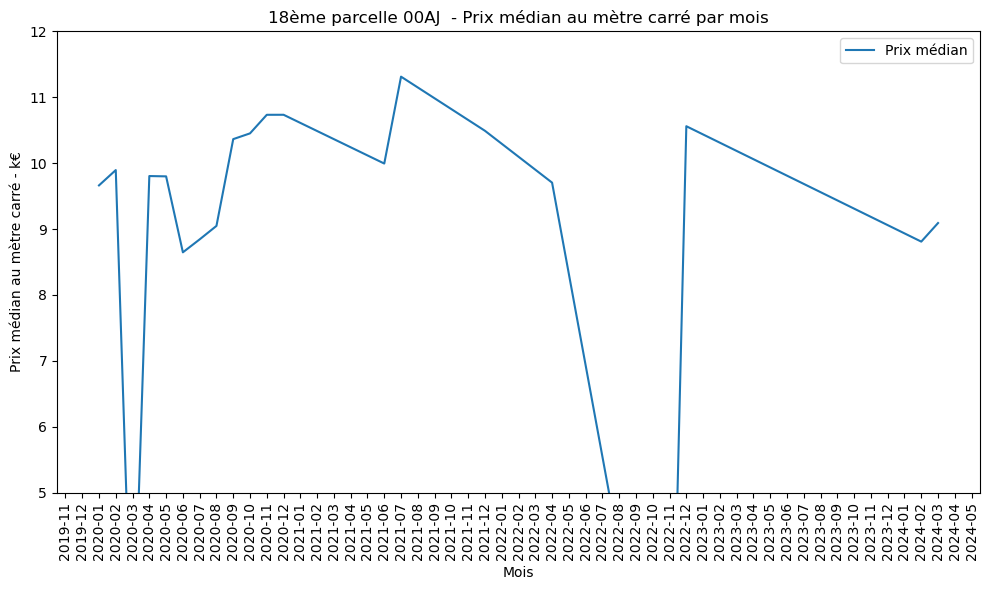

In [181]:
# Plot the line plot using Seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df_marche_18, x='annee_mois', y='prix_m2')
sns.lineplot(data=df_marche_AJ, x='annee_mois', y='50%_rol_6m', label='Prix médian')
# sns.lineplot(data=df_marche_AJ, x='annee_mois', y='25%_rol_6m', label='Quartile 1 (25%)')
# sns.lineplot(data=df_marche_AJ, x='annee_mois', y='75%_rol_6m', label = 'Quartile 3 (75%)')


plt.title('18ème parcelle 00AJ  - Prix médian au mètre carré par mois')
plt.xlabel('Mois')
plt.ylabel('Prix médian au mètre carré - k€')
plt.ylim(5, 12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [118]:
df_marche_AJ.sort_index(ascending=False).head(30)

,annee_mois,placer,count,mean,std,min,25%,50%,75%,max,count_rol_6m,mean_rol_6m,std_rol_6m,min_rol_6m,25%_rol_6m,50%_rol_6m,75%_rol_6m,max_rol_6m
59,2024-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,2024-05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,2024-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,2024-03,0,5.0,9.512006,1.18905,8.181818,8.871202,9.090909,10.240627,11.175472,5.0,9.512006,1.18905,8.181818,8.871202,9.090909,10.240627,11.175472
55,2024-02,0,1.0,8.808750,NaN,8.808750,8.808750,8.808750,8.808750,8.808750,1.0,8.808750,NaN,8.808750,8.808750,8.808750,8.808750,8.808750
54,2024-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,2023-12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,2023-11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,2023-10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,2023-09,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Bonnes rues Joseph de Maistre

In [119]:
## 18ème - prix moyen m2
df_parcelle=df_raw.loc[(df_raw.nature_mutation=='Vente')
                    &(df_raw.type_local=='Appartement')
                    &(df_raw.code_postal=='75018')
                    &(df_raw.section_prefixe=="000AJ")
                    &((df_raw.adresse_nom_voie=="RUE COYSEVOX")
                      |(df_raw.adresse_nom_voie=="RUE MARCADET")
                      |(df_raw.adresse_nom_voie=="RUE JOSEPH DE MAISTRE"))]


# Group by month and calculate the average 'prix_m2'
df_local=compute_avg_market_month(df_parcelle)

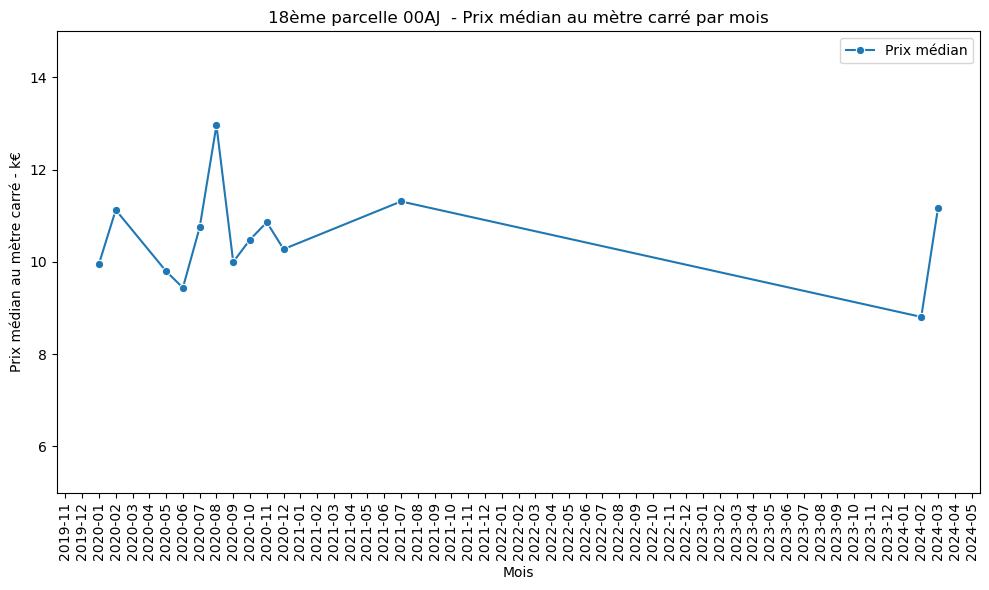

In [120]:
# Plot the line plot using Seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df_marche_18, x='annee_mois', y='prix_m2')
sns.lineplot(data=df_local, x='annee_mois', y='50%_rol_6m', label='Prix médian',marker='o', dashes=False)
# sns.lineplot(data=df_local, x='annee_mois', y='25%_rol_6m', label='Quartile 1 (25%)')
# sns.lineplot(data=df_local, x='annee_mois', y='75%_rol_6m', label = 'Quartile 3 (75%)')


plt.title('18ème parcelle 00AJ  - Prix médian au mètre carré par mois')
plt.xlabel('Mois')
plt.ylabel('Prix médian au mètre carré - k€')
# Set the y-axis scale between 0 and 10
plt.ylim(5, 15)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [121]:
df_local.sort_index(ascending=False).head(20)

,annee_mois,placer,count,mean,std,min,25%,50%,75%,max,count_rol_6m,mean_rol_6m,std_rol_6m,min_rol_6m,25%_rol_6m,50%_rol_6m,75%_rol_6m,max_rol_6m
59,2024-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,2024-05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,2024-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,2024-03,0,1.0,11.175472,NaN,11.175472,11.175472,11.175472,11.175472,11.175472,1.0,11.175472,NaN,11.175472,11.175472,11.175472,11.175472,11.175472
55,2024-02,0,1.0,8.808750,NaN,8.808750,8.808750,8.808750,8.808750,8.808750,1.0,8.808750,NaN,8.808750,8.808750,8.808750,8.808750,8.808750
54,2024-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,2023-12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,2023-11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,2023-10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,2023-09,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
df_parcelle.sort_values(by='date_mutation',ascending=False).head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,section_prefixe,annee_mois,total_surface_carrez,prix_m2
295688,2024-540684,2024-03-01,1.0,Vente,592300.0,78.0,B,RUE JOSEPH DE MAISTRE,5010,75018,75118,Paris 18e Arrondissement,75,NaN,NaN,75118000AJ0011,NaN,NaN,29.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2,Appartement,53.0,3,NaN,NaN,NaN,NaN,NaN,2.3309090,48.8920870,000AJ,2024-03,0.00,11.175472
295430,2024-540542,2024-02-26,1.0,Vente,298000.0,227.0,NaN,RUE MARCADET,5995,75018,75118,Paris 18e Arrondissement,75,NaN,NaN,75118000AJ0017,NaN,NaN,16.0,NaN,4.0,33.83,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2,Appartement,36.0,2,NaN,NaN,NaN,NaN,NaN,2.3313800,48.8919910,000AJ,2024-02,33.83,8.808750
149923,2021-1689896,2021-07-06,1.0,Vente,200000.0,22.0,NaN,RUE COYSEVOX,2418,75018,75118,Paris 18e Arrondissement,75,NaN,NaN,75118000AJ0038,NaN,NaN,30.0,17.68,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2,Appartement,18.0,1,NaN,NaN,NaN,NaN,NaN,2.3302390,48.8920870,000AJ,2021-07,17.68,11.312217
358209,2020-1458858,2020-12-15,1.0,Vente,233500.0,33.0,NaN,RUE JOSEPH DE MAISTRE,5010,75018,75118,Paris 18e Arrondissement,75,NaN,NaN,75118000AJ0034,NaN,NaN,17.0,NaN,40.0,39.28,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2,Appartement,38.0,2,NaN,NaN,NaN,NaN,NaN,2.3304260,48.8919160,000AJ,2020-12,39.28,5.944501
358075,2020-1458744,2020-11-30,1.0,Vente,230000.0,21.0,NaN,RUE COYSEVOX,2418,75018,75118,Paris 18e Arrondissement,75,NaN,NaN,75118000AJ0044,NaN,NaN,16.0,23.23,17.0,NaN,19.0,NaN,NaN,NaN,NaN,NaN,3.0,2,Appartement,24.0,2,NaN,NaN,NaN,NaN,NaN,2.3296730,48.8919510,000AJ,2020-11,23.23,9.900990


## Appartements tailles comparables

In [189]:
## 18ème - prix moyen m2
df_comp=df_raw.loc[(df_raw.nature_mutation=='Vente')
                    &(df_raw.type_local=='Appartement')
                    &(df_raw.code_postal=='75018')
                    &(df_raw.adresse_nom_voie=="RUE JOSEPH DE MAISTRE")
                    # &(df_raw.nombre_pieces_principales=="2")
                    # &(df_raw.total_surface_carrez<=50)
                    # &(df_raw.total_surface_carrez>=40)
                    
                    ]

# Group by month and calculate the average 'prix_m2'
df_marche_comp=compute_avg_market_month(df_comp)

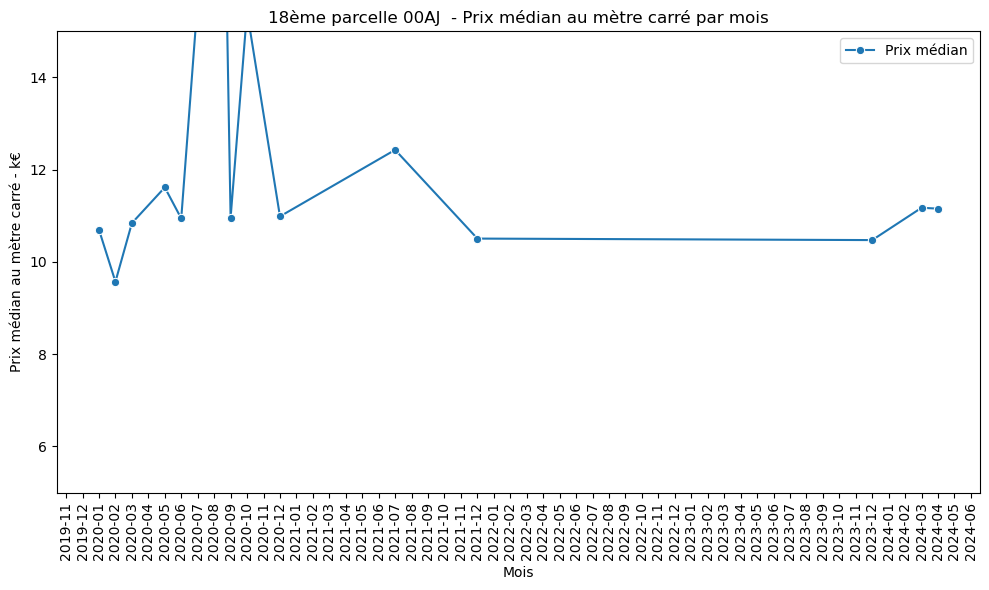

In [190]:
# Plot the line plot using Seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df_marche_18, x='annee_mois', y='prix_m2')
sns.lineplot(data=df_marche_comp, x='annee_mois', y='50%_rol_6m', label='Prix médian',marker='o', dashes=False)
# sns.lineplot(data=df_marche_comp, x='annee_mois', y='25%_rol_6m', label='Quartile 1 (25%)')
# sns.lineplot(data=df_marche_comp, x='annee_mois', y='75%_rol_6m', label = 'Quartile 3 (75%)')


plt.title('18ème parcelle 00AJ  - Prix médian au mètre carré par mois')
plt.xlabel('Mois')
plt.ylabel('Prix médian au mètre carré - k€')
# Set the y-axis scale between 0 and 10
plt.ylim(5, 15)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [191]:
df_marche_comp.sort_index(ascending=False)

,annee_mois,placer,count,mean,std,min,25%,50%,75%,max,count_rol_6m,mean_rol_6m,std_rol_6m,min_rol_6m,25%_rol_6m,50%_rol_6m,75%_rol_6m,max_rol_6m
59,2024-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,2024-05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,2024-04,0,2.0,11.155542,0.412023,10.864198,11.009870,11.155542,11.301214,11.446886,2.000000,11.155542,0.412023,10.864198,11.009870,11.155542,11.301214,11.446886
56,2024-03,0,3.0,11.274688,3.864314,7.460938,9.318205,11.175472,13.181563,15.187654,3.000000,11.274688,3.864314,7.460938,9.318205,11.175472,13.181563,15.187654
55,2024-02,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,2024-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,2023-12,0,1.0,10.474356,NaN,10.474356,10.474356,10.474356,10.474356,10.474356,1.000000,10.474356,NaN,10.474356,10.474356,10.474356,10.474356,10.474356
52,2023-11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,2023-10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,2023-09,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
[x for x in df_raw.columns if 'nombre' in x]

['nombre_lots', 'nombre_pieces_principales']

In [194]:
df_comp.loc[
            :,['date_mutation','nombre_lots', 'adresse_numero','adresse_nom_voie', 'adresse_code_voie',
               'section_prefixe','surface_reelle_bati', 'nombre_pieces_principales','valeur_fonciere','total_surface_carrez', 'prix_m2']
            ].sort_values(by='date_mutation',ascending=False)

,date_mutation,nombre_lots,adresse_numero,adresse_nom_voie,adresse_code_voie,section_prefixe,surface_reelle_bati,nombre_pieces_principales,valeur_fonciere,total_surface_carrez,prix_m2
299852,2024-04-23,2.0,50.0,RUE JOSEPH DE MAISTRE,5010,000AK,81.0,5,880000.0,0.00,10.864198
299940,2024-04-17,2.0,3.0,RUE JOSEPH DE MAISTRE,5010,000AQ,43.0,2,500000.0,43.68,11.446886
296491,2024-03-19,1.0,10.0,RUE JOSEPH DE MAISTRE,5010,000AS,81.0,3,1230200.0,0.00,15.187654
295986,2024-03-12,2.0,54.0,RUE JOSEPH DE MAISTRE,5010,000AK,64.0,3,477500.0,0.00,7.460938
295688,2024-03-01,2.0,78.0,RUE JOSEPH DE MAISTRE,5010,000AJ,53.0,3,592300.0,0.00,11.175472
99316,2023-12-06,2.0,62.0,RUE JOSEPH DE MAISTRE,5010,000AK,39.0,2,435000.0,41.53,10.474356
247610,2021-12-08,1.0,5.0,RUE JOSEPH DE MAISTRE,5010,000AQ,32.0,2,334750.0,31.86,10.506905
149711,2021-07-23,2.0,64.0,RUE JOSEPH DE MAISTRE,5010,000AK,54.0,3,703650.0,0.00,13.030556
148085,2021-07-01,1.0,42.0,RUE JOSEPH DE MAISTRE,5010,000AT,26.0,2,307575.0,0.00,11.829808
358486,2020-12-17,2.0,46.0,RUE JOSEPH DE MAISTRE,5010,000AK,29.0,2,346000.0,31.49,10.987615
